In [4]:
from IPython.display import Audio 
from librosa import display
from matplotlib import pyplot as plt
from pathlib import Path
from ipywidgets import interactive

import glob
import librosa
import numpy as np
import os
import pandas as pd
import scipy
import seaborn as sns


file_path_normal = r"../../data/decomposition/slider/test/normal_id_00_00000000_1.wav"
file_path_anomaly = r"../../data/decomposition/slider/test/anomaly_id_00_00000000_1.wav"

samples_normal, sampling_rate_normal = librosa.load(file_path_normal, sr=None, mono=True, offset=0.0, duration=None)
samples_anomaly, sampling_rate_anomaly = librosa.load(file_path_anomaly, sr=None, mono=True, offset=0.0, duration=None)
len(samples_normal), sampling_rate_normal


(24000, 16000)

In [5]:
def fft_plot(audio, sampling_rate):
    n = len(audio)
    T = 1 / sampling_rate
    yf = scipy.fft.fft(audio, n=sampling_rate*2)
    xf = np.linspace(0.0, 1.0/(2.0*T), sampling_rate)
    fig, ax = plt.subplots()
    ax.plot(xf, 2.0/sampling_rate * np.abs(yf[:sampling_rate]))
    plt.grid()
    plt.xlabel("Frequency")
    plt.ylabel("Magnitude")
    
    return plt.show()

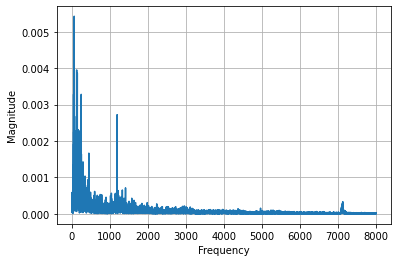

In [6]:
fft_plot(samples_normal, sampling_rate_normal)
# np.linspace(0.0, 8000.0, 80000)

In [18]:
Audio(file_path)

Text(0, 0.5, 'Amplitude')

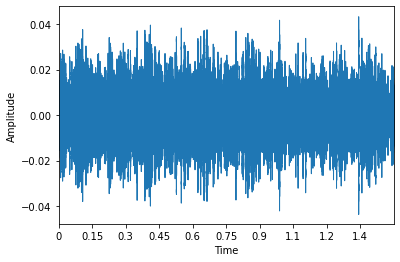

In [7]:
plt.figure()
librosa.display.waveplot(y=samples_normal, sr=sampling_rate_normal)
plt.ylabel("Amplitude")

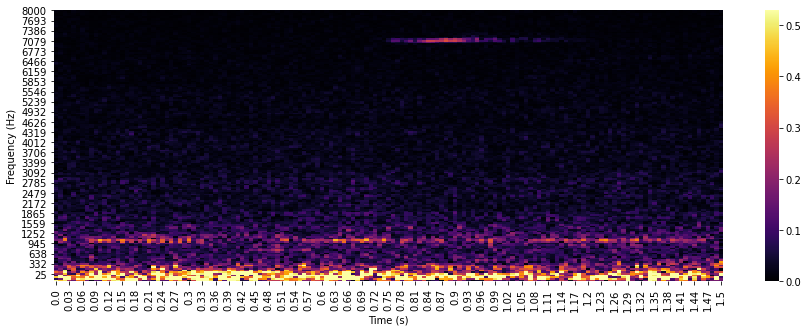

In [8]:
def spectrogram(audio, fe, dt):
    return np.abs(librosa.stft(audio,
                        n_fft = int(dt*fe),
                        hop_length = int(dt*fe/2)
                        )
                 )

def plot_spectrogram(audio, fe, dt=0.02):
    im = spectrogram(audio, fe, dt)
    sns.heatmap(np.rot90(im.T), cmap='inferno', vmin=0, vmax=np.max(im)/3)
    loc, labels = plt.xticks()
    l = np.round((loc-loc.min())*len(audio)/fe/loc.max(), 2)
    plt.xticks(loc, l)
    loc, labels = plt.yticks()
    l = np.array(loc[::-1]*fe/2/loc.max(), dtype=int)
    plt.yticks(loc, l)
    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (Hz)")

plt.figure(figsize=(15,5))
plot_spectrogram(samples_normal, sampling_rate_normal)

c:\users\qfich\miniconda3\envs\tf-gpu\lib\site-packages\librosa\filters.py:238: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn(


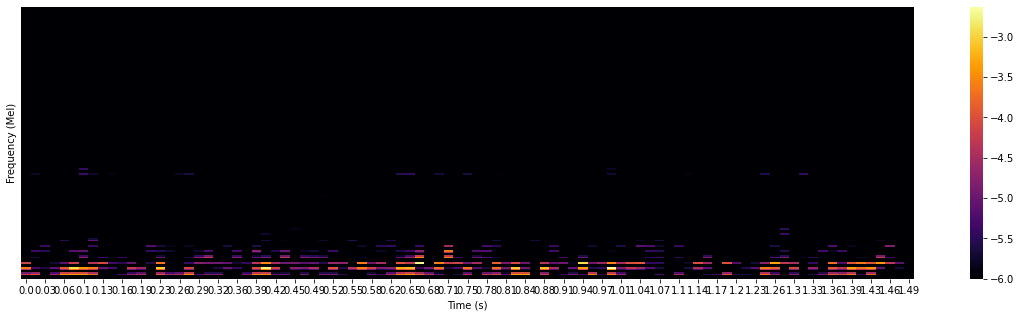

In [29]:
params = {
    'n_fft': 128*2,
    'frame_step': 128*2,
    'lower_edge_hertz': 0,
    'upper_edge_hertz': 8000,
    'num_mel_bins': 160
}

def logMelSpectrogram(audio, params, fe):

    stfts = librosa.stft(audio,
                        n_fft = int(params['n_fft']),
                        hop_length = int(params["frame_step"]),
                        center = False
                        ).T
    power_spectrograms = np.real(stfts * np.conj(stfts))


    linear_to_mel_weight_matrix = librosa.filters.mel(
                                sr=fe,
                                n_fft=int(params['n_fft']) + 1,
                                n_mels=params['num_mel_bins'],
                                fmin=params['lower_edge_hertz'],
                                fmax=params['upper_edge_hertz']
                    ).T

    mel_spectrograms = np.tensordot(
                power_spectrograms,
                linear_to_mel_weight_matrix,
                1
            )

    return (np.log(mel_spectrograms + 1e-8).astype(np.float16))


def plot_logMelSpectrogram(audio, params, fe):
    sns.heatmap(np.rot90(logMelSpectrogram(audio, params, fe)), cmap='inferno', vmin = -6)
    loc, labels = plt.xticks()
    l = np.round((loc-loc.min())*len(audio)/fe/loc.max(), 2)
    plt.xticks(loc, l)
    plt.yticks([])
    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (Mel)")
    
    
plt.figure(figsize=(20,5))
plot_logMelSpectrogram(samples_normal, params, sampling_rate_normal)

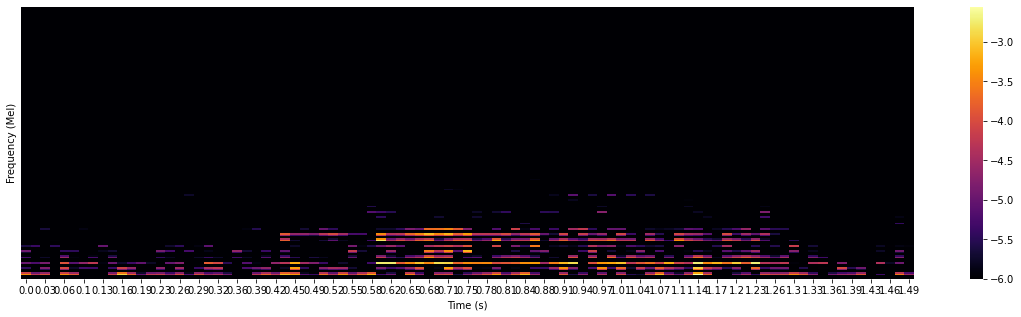

In [30]:
plt.figure(figsize=(20,5))
plot_logMelSpectrogram(samples_anomaly, params, sampling_rate_anomaly)

In [122]:
datas = []

for filename in glob.iglob('data/**/train/*.wav', recursive = True): 
    samples, sampling_rate = librosa.load(filename, sr=None, mono=True, offset=0.0, duration=None)
    yf = scipy.fft.fft(samples, n=sampling_rate*2)
#     print(len(list(2.0/sampling_rate * np.abs(yf[:sampling_rate]))))
    datas.append(list(2.0/sampling_rate * np.abs(yf[:sampling_rate])))
#     datas.append(scipy.fft.fft(samples, n=sampling_rate*2)[:sampling_rate])

datas = np.array(datas)
# datas.shape
    
df = pd.DataFrame(datas)
df.to_csv("data.csv")

NameError: name 'audio' is not defined

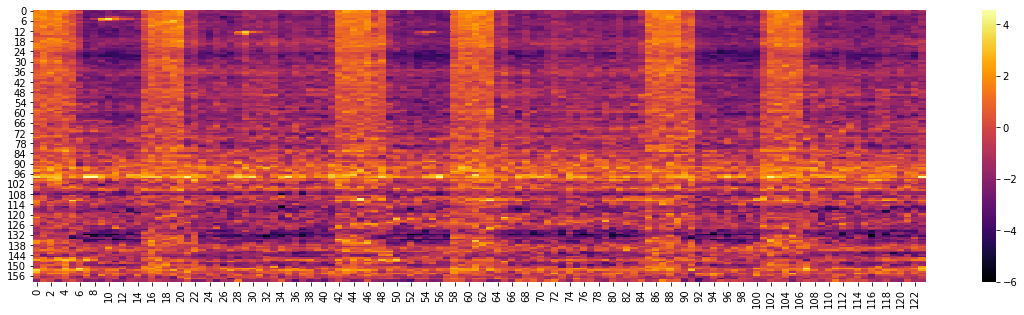

In [12]:
normal_amp = np.rot90(logMelSpectrogram(samples_normal, params, sampling_rate_normal))
anormal_amp = np.rot90(logMelSpectrogram(samples_anomaly, params, sampling_rate_normal))

plt.figure(figsize=(20,5))
sns.heatmap(normal_amp - anormal_amp, cmap='inferno', vmin = -6)
loc, labels = plt.xticks()
l = np.round((loc-loc.min())*len(audio)/fe/loc.max(), 2)
plt.xticks(loc, l)
plt.yticks([])
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Mel)")